# Детекция. YOLO

In [ ]:
!pip3 install ultralytics -qq       # YOLO
!pip3 install opencv-python         # CV2 для захвата с камеры

### Варианты YOLOV11  

![Screenshot from 2024-10-04 16-12-40.png](<attachment:Screenshot from 2024-10-04 16-12-40.png>)
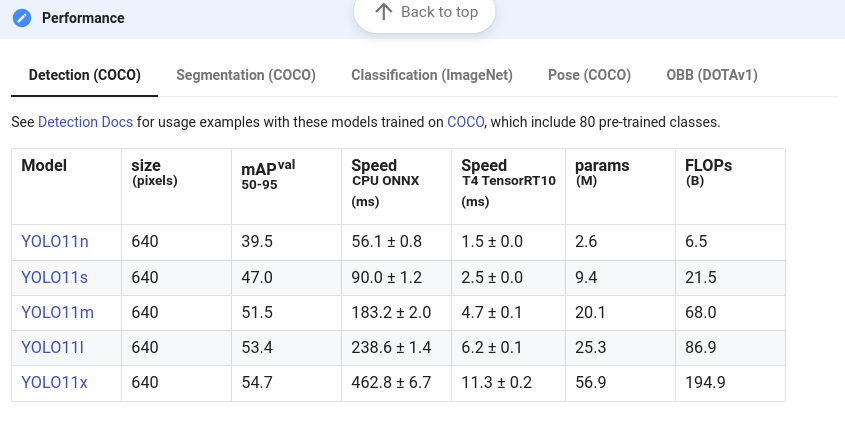

Модель YOLOV11 вышла в сентябре 2024 года

Существуют варианты модели для
- детекции, детекции с учётом ориентации
- классификации
- instance segmentation
- pose \ keypoints extraction

В моделях реализован методы отслеживания - `track()`

Документация: https://docs.ultralytics.com/#introduction

### Загрузка предварительно обученной модели

In [2]:
from ultralytics import YOLO

In [ ]:
# doc: https://docs.ultralytics.com/reference/engine/model/#ultralytics.engine.model.Model
model = YOLO("yolo11n.pt")
model.info(detailed = True) 
# doc: shows detailed information about the model layers and parameters 🤷
# ???, количество параметров, ???, FLOPS?

In [ ]:
# имена классов, которые распознаёт обученная модель
LabelNames = model.names
LabelNames

### Распознавание на изображении

In [28]:
# изображение для проверки
!wget https://deepstackpython.readthedocs.io/en/latest/_images/test-image3.jpg --quiet -nc # -nc -- не перезаписывать файл есть он есть
image_path = "test-image3.jpg"

In [ ]:
# применение модели
result = model( image_path )        # возвращает список, длина списка = кол-во изображений?
# классы
[ LabelNames[int(c)] for c in result[0].boxes.cls ]

#### Нарисовать рамки объектов

In [71]:
# чтобы легче отличать рамку от фона стоит рисовать её пунктиром

def draw_dashed_rectangle(draw, xy, fill=None, width=1):
    """Рисует пунктирный прямоугольник"""
    x1, y1, x2, y2 = xy
    
    def draw_dashed_line(draw, start, end, dash_length=5, gap_length=5, fill='white', width=1):
        x1, y1 = start
        x2, y2 = end
        
        if x1 == x2:  # vertical line
            for y in range(y1, y2, dash_length + gap_length):
                draw.line([(x1, y), (x1, min(y + dash_length, y2))], fill=fill, width=width)
        else:  # horizontal line
            for x in range(x1, x2, dash_length + gap_length):
                draw.line([(x, y1), (min(x + dash_length, x2), y1)], fill=fill, width=width)
    # todo: пофиксить, чтобы можно было задавать два цвета и рисовать в любом направлении
    draw_dashed_line(draw, (x1, y1), (x2, y1))  # Top
    draw_dashed_line(draw, (x2, y1), (x2, y2))  # Right
    draw_dashed_line(draw, (x1, y2), (x2, y2))  # Bottom
    draw_dashed_line(draw, (x1, y1), (x1, y2), )  # Left

In [72]:
from PIL import Image, ImageDraw, ImageFont
image = Image.open(image_path)

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

for result in result:
    boxes = result.boxes
    for box in boxes:
        # Координаты рамки
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Класс и уверенность
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        label = f"{result.names[class_id]} {confidence:.2f}"

        # Рисуем рамку
        # draw.rectangle([x1, y1, x2, y2], outline="yellow", width=2)
        draw_dashed_rectangle(draw, [x1, y1, x2, y2], fill="yellow")
        # Добавляем текст
        draw.text((x1, y1 - 15), label, fill="yellow", font=font)

# Сохранение изображения
# image.save("output_pil.jpg")
image.show()

# Распознавание по видео с камеры

In [73]:
import cv2
import logging
import time
from ultralytics import YOLO


# person - 0
# cat - 15
# wine glass - 40
# cup - 41
# cell phone - 67
# book - 73


# Отключение логирования, чтобы не выводить информацию про детекцию на каждом кадре
logging.getLogger("ultralytics").setLevel(logging.CRITICAL)
model = YOLO("yolo11s.pt", verbose=False)  # Подключи свою модель

# Открытие веб-камеры
cap = cv2.VideoCapture(0)


# для подсчёта FPS
prev_time = 0

if not cap.isOpened():
    print("Не удалось открыть камеру")
    exit()

while True:
    # Получение текущего времени для подсчёта FPS
    current_time = time.time()
    # Вычисление FPS
    fps = 1 / (current_time - prev_time)
    prev_time = current_time

    # Чтение фрейма с камеры
    ret, frame = cap.read()
    if not ret:
        print("Не удалось получить фрейм")
        break

    # Выполнение предсказания с помощью YOLO
    results = model(frame, max_det=10, conf=0.5, classes = [0,15, 40, 41, 67, 73])
    # максимум 10 объектов, минимальная уверенность детекции любого? объекта - conf, classes - набор классов, которые нужно искать

    # Проход по результатам
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Координаты рамки
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Класс и уверенность
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            label = f"{result.names[class_id]} {confidence:.2f}"

            # Рисование рамки и подписи
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Отображение FPS на видео
    fps_text = f"FPS: {fps:.0f}"
    cv2.putText(frame, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    # Показ фрейма с результатами
    cv2.imshow("YOLO Detection", frame)

    # Выход по нажатию клавиши 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Закрытие всех окон
cap.release()
cv2.destroyAllWindows()
